<a href="https://colab.research.google.com/github/saclele/American-Sign-Language-Detection-using-Computer-Vision/blob/master/ASL_Classification_with_Attention_Maps_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'asl-alphabet:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F23079%2F29550%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T185824Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D416ad7cb8e527dce4386f1017bd232b1ab0e11c7197527b09d655801a960d8884fd0b1ed9c54fae5fb7f279b2a5337b37f154d18c9fbb9bf54844bbfe8c7b65baa7cac2f7a5ccd2e073594d43de6cd05add6c4c0796000384efaa5583ef2c9ad8174f9aee5af0c1e1d461ef3925e60ed1760c5bf42320b56adebb823624c7f8e96df170e4025f11f942a56b1ae7948b9bd722ff0f767996f4d808b77be131c284a8299346ee953959c720cce980cc97c42641c91fcf55f76ad4574661cc9773addd2636a1e5bd1466ec08010125f767ddbf7e64f2e875115ea08de46893177d53eb229e05fe979cf65e042dcd533dd2a35d77dc75e3d2176cbf45b88f0b880e6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1100887034 bytes downloaded
Downloaded and uncompressed: asl-alphabet
Data source import complete.


In [2]:
!pip install torchsummary

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
from torchsummary import summary

BS=64
IS=224
epochs=5
LR=0.0005
device='cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()

train_augs=transforms.Compose([
    transforms.Resize(IS),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,0,0),std=(1,1,1)),
])

train_dir_path='/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
trainset=torchvision.datasets.ImageFolder(train_dir_path,transform=train_augs)
trainloader=torch.utils.data.DataLoader(trainset, batch_size=BS, shuffle=True)

print(f'Training Data:- {len(trainset)} images divided into {len(trainloader)} batches')

Training Data:- 87000 images divided into 1360 batches


#### Model

In [4]:
criterion=nn.CrossEntropyLoss()
num_classes=len(trainset.classes)

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        self.feature_extractor=nn.Sequential(
                                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=2),
                                nn.MaxPool2d(3,2),
                                nn.ReLU(),

                                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2),
                                nn.MaxPool2d(3,2),
                                nn.ReLU(),

                                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2),
                                nn.ReLU(),
                                )
        self.linear=nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(1024,100),
                    nn.ReLU(),
                    nn.Linear(100,num_classes)
                    )

        self.gradeints=None

    def activation_hook(self, grad):
        self.gradients=grad

    def forward(self, image, label=None):
        x1=self.feature_extractor(image)
        h=x1.register_hook(self.activation_hook)

        x2=self.linear(x1)

        if label!=None:
            loss=criterion(x2, label)
            return loss, x2

        return x2

    def get_activation_maps(self,x1):
        return self.feature_extractor(x1)

    def get_gradients(self):
        return self.gradients

model=Classifier()
model.to(device);
summary(model, input_size=(3,IS,IS))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 110, 110]           1,216
         MaxPool2d-2           [-1, 16, 54, 54]               0
              ReLU-3           [-1, 16, 54, 54]               0
            Conv2d-4           [-1, 32, 25, 25]          12,832
         MaxPool2d-5           [-1, 32, 12, 12]               0
              ReLU-6           [-1, 32, 12, 12]               0
            Conv2d-7             [-1, 64, 4, 4]          51,264
              ReLU-8             [-1, 64, 4, 4]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                  [-1, 100]         102,500
             ReLU-11                  [-1, 100]               0
           Linear-12                   [-1, 29]           2,929
Total params: 170,741
Trainable params: 170,741
Non-trainable params: 0
-------------------------------

#### Training

In [5]:
bl=np.Inf
opt=torch.optim.Adam(model.parameters(),lr=LR)

def trainarc(model, dataloader, opt):
    model.train()
    train_loss=0.0
    for images, labels in tqdm(dataloader):

        images=images.to(device)
        labels=labels.to(device)

        opt.zero_grad()
        loss,pred = model(images, labels)
        loss.backward()
        opt.step()

        train_loss+=loss
    return train_loss/len(dataloader)


for i in range(epochs):
    l=trainarc(model,trainloader,opt)
    print(f'E: {i+1}/{epochs}:- Loss: {l}')
    if l<bl:
        torch.save(model.state_dict(),'/kaggle/working/model.pt')
        print('Model Updated')
        bl=l
print(f"Done. Best Loss: {bl}")

  0%|          | 0/1360 [00:00<?, ?it/s]

E: 1/5:- Loss: 1.682243824005127
Model Updated


  0%|          | 0/1360 [00:00<?, ?it/s]

E: 2/5:- Loss: 0.531577467918396
Model Updated


  0%|          | 0/1360 [00:00<?, ?it/s]

E: 3/5:- Loss: 0.3051094710826874
Model Updated


  0%|          | 0/1360 [00:00<?, ?it/s]

E: 4/5:- Loss: 0.20799380540847778
Model Updated


  0%|          | 0/1360 [00:00<?, ?it/s]

E: 5/5:- Loss: 0.150657519698143
Model Updated
Done. Best Loss: 0.150657519698143


#### Model Inference

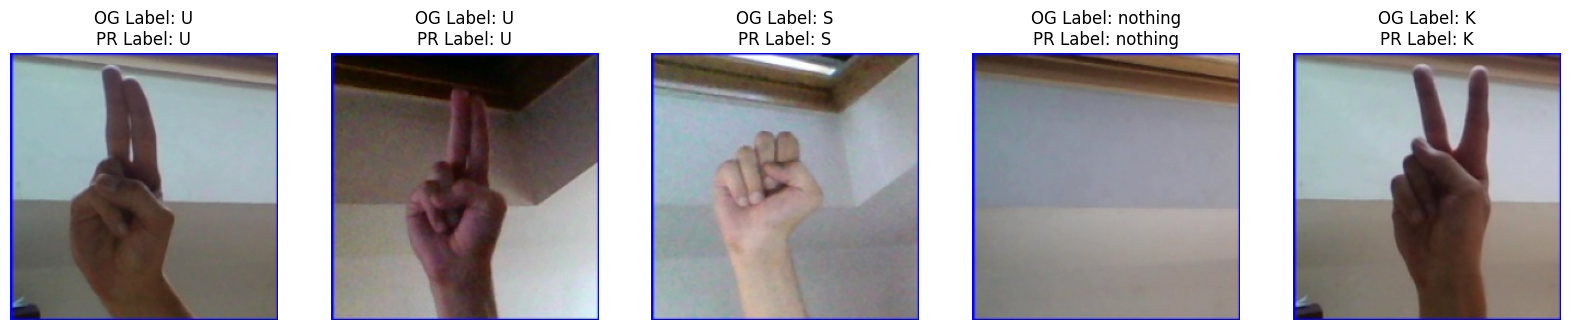

In [6]:
import random

plt.figure(figsize=(20,10))
n=5
for i in range(n):
    idx=random.randint(0,len(trainset))
    image, label = trainset[idx]
    pred = model(image.unsqueeze(0).to(device))
    plt.subplot(1,n,i+1)
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.title('OG Label: '+trainset.classes[label]+'\n'+'PR Label: '+trainset.classes[torch.argmax(pred).item()])

#### GradCAM

In [7]:
idx=random.randint(0,len(trainset))
image, label = trainset[idx]
pred = model(image.unsqueeze(0).to(device))
pred[0][torch.argmax(pred).item()].backward()

act_maps=model.get_activation_maps(image.unsqueeze(0).to(device))
gradients=model.get_gradients()

pooled_gradients=torch.mean(gradients,dim=[0,2,3])

for i in range(act_maps.shape[1]):
    act_maps[:,i,:,:] = act_maps[:,i,:,:]*pooled_gradients[i]

heatmap=torch.mean(act_maps, dim=1).squeeze(0).detach().cpu()
heatmap=nn.ReLU()(heatmap)
heatmap/=torch.max(heatmap)
resized_heatmap=cv2.resize(heatmap.numpy(),(IS,IS))

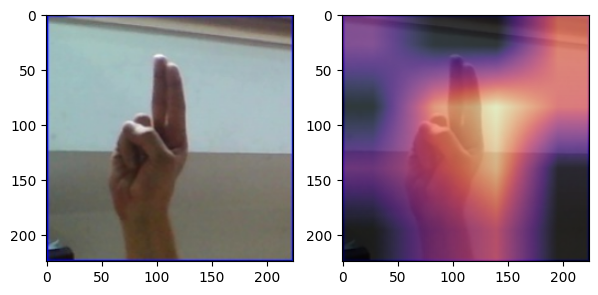

In [8]:
def plot_heatmap(denorm_image, pred, heatmap):
    fig, (ax1, ax2) = plt.subplots(figsize=(7,5), ncols=2)

    ax1.imshow(denorm_image)
    ax2.imshow(denorm_image)
    ax2.imshow(heatmap, cmap='magma', alpha=0.7)

plot_heatmap(image.permute(1,2,0), pred, resized_heatmap)

#### Model Evaluation

In [9]:
y_true, y_pred = [],[]

for images, labels in trainloader:
    images=images.to(device)
    pred=model(images)
    y_true.append(labels.tolist())
    y_pred.append(torch.argmax(pred,dim=1).tolist())
    break

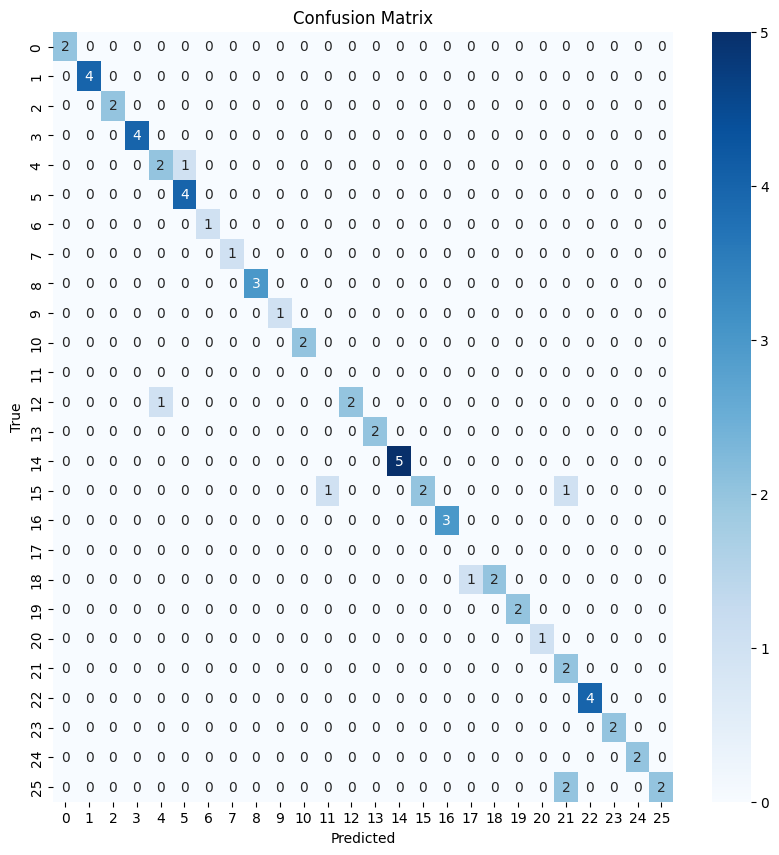

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true[0], y_pred[0])

# Visualize confusion matrix as a heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()